# Converts RGB, segmentation maps into COCO

Defines the class `COCOCreator`, that creates a COCO-style json for a Replica scene. 

Example usage:
```
c = CocoCreator(<root_data_dir>, <location of replica semantic json>, <list of labels>)
c.create_coco(
    scene='apartment_0', # replica scene name
    coco_file_name='sample.json', # output file name
    seg_folder='seg', # location of segmentation maps
    pct=1 # percentage of segmentation maps to use, always 1 when creating a set on propagated labels
)
```

In [1]:
import numpy as np
import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

import cv2
import random
import os
import numpy as np
import json
from matplotlib import pyplot as plt
from PIL import Image
from pycococreatortools import pycococreatortools
from IPython import embed
from tqdm import tqdm
from IPython.core.display import display, HTML
import os
import shutil
import glob 
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer, ColorMode

# labels = ['chair', 'cushion', 'door', 'indoor-plant', 'table', 'vase']
# labels= ['chair', 'cushion', 'door', 'lamp', 'sofa', 'table']
labels = ['chair', 'cushion', 'door', 'indoor-plant', 'sofa', 'table']
# Takes the output of data collection and label prop, ideally these live in the same folder called root, scene 
root_dir = '/checkpoint/apratik/finals/'
scene = 'apartment_0'
output_json = 'default_apt0.json'
semantic_json_root = '/checkpoint/apratik/ActiveVision/active_vision/info_semantic'


class CocoCreator:
    
    # Assumes root_data_dir has both te GT and propagated segmentation labels
    def __init__(self, root_data_dir, semantic_json_root, labels):
        self.rdd = root_data_dir
        self.sjr = semantic_json_root
        self.labels = labels
        sorted(self.labels)
        print(f"Init CocoCreator for labels {self.labels}")
        
    def create_coco(self, scene, coco_file_name, seg_folder, pct):
        hsd = self.load_semantic_json(scene)
        self.create_metadata(hsd)
        self.create_annos(hsd, scene, seg_folder, pct)
        self.save_json(coco_file_name)
        self.visualize_annos(coco_file_name, scene)
    
    def visualize_annos(self, coco_file_name, scene):
        DatasetCatalog.clear()
        MetadataCatalog.clear()

        register_coco_instances('foobar', {}, coco_file_name, os.path.join(self.rdd, scene, 'rgb'))
        MetadataCatalog.get('foobar')
        dataset_dicts = DatasetCatalog.get('foobar')

        for d in random.sample(dataset_dicts, 2):
            img = cv2.imread(d["file_name"])
            print(d['file_name'])
            visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get('foobar'), scale=0.5)
            vis = visualizer.draw_dataset_dict(d)
            img = vis.get_image()
            plt.figure(figsize=(12 , 8))
            plt.imshow(img)
            plt.show()
        
    def save_json(self, coco_file_name):
        coco_output = {
            "info": self.INFO,
            "licenses": self.LICENSES,
            "categories": self.CATEGORIES,
            "images": self.IMAGES,
            "annotations": self.ANNOTATIONS,
        }
        
        print(f"Dumping annotations to {coco_file_name}")
        with open(coco_file_name, "w") as output_json:
            json.dump(coco_output, output_json)
    
    def create_annos(self, hsd, scene, seg, pct):
        coco_img_id = -1
        count = 0
        segm_dir = os.path.join(self.rdd, scene, seg)
        print(f"Scene {scene}, seg dir {segm_dir}")       
        img_dir = os.path.join(self.rdd, scene, 'rgb')
        fs = self.get_segm_files(segm_dir, pct)
        print(f"Creating COCO annotations for {len(fs)} images \n img_dir {img_dir}")
        
        for f in tqdm(fs):
            image_id = int(f.split('.')[0])
            try:
                prop_path = os.path.join(segm_dir, "{:05d}.npy".format(image_id))
                annot = np.load(prop_path).astype(np.uint32)
            except Exception as e:
                print(e)
                continue


            img_filename = "{:05d}.jpg".format(image_id)            
            img = Image.open(os.path.join(img_dir, img_filename))

            # COCO ID and names
            coco_img_id += 1

            image_info = pycococreatortools.create_image_info(
                coco_img_id, os.path.basename(img_filename), img.size
            )

            self.IMAGES.append(image_info)
        
            # for each annotation add to coco format
            for i in np.sort(np.unique(annot.reshape(-1), axis=0)):
                try:
                    if hsd["id_to_label"][i] < 1 or self.label_id_dict[hsd["id_to_label"][i]] not in labels:# or hsd["id_to_label"][i] not in self.label_id_dict:
                        continue
                    category_info = {"id": self.new_old_id[hsd["id_to_label"][i]], "is_crowd": False}
#                     print(f'category_info {category_info}')
                except:
                    continue

                binary_mask = (annot == i).astype(np.uint32)

                annotation_info = pycococreatortools.create_annotation_info(
                    count, coco_img_id, category_info, binary_mask, img.size, tolerance=2
                )
                if annotation_info is not None:
                    self.ANNOTATIONS.append(annotation_info)
                    count += 1
        
        
    def create_metadata(self, hsd):
        self.INFO = {}
        self.LICENSES = [{}]
        self.CATEGORIES = []
        self.IMAGES = []
        self.ANNOTATIONS = []
        
        self.label_id_dict = {}
        self.new_old_id = {}
        idc = 1
        for obj_cls in hsd["classes"]:
            if obj_cls["name"] in self.labels:
                self.CATEGORIES.append({"id": idc, "name": obj_cls["name"], "supercategory": "shape"})
                self.label_id_dict[obj_cls["id"]] = obj_cls["name"]
                self.new_old_id[obj_cls['id']] = idc
                idc += 1
        
        
    def load_semantic_json(self, scene):
        replica_root = '/datasets01/replica/061819/18_scenes'
        habitat_semantic_json = os.path.join(replica_root, scene, 'habitat', 'info_semantic.json')
        print(f"Using habitat semantic json {habitat_semantic_json}")
        with open(habitat_semantic_json, "r") as f:
            hsd = json.load(f)
        if hsd is None:
            print("Semantic json not found!")
        return hsd
    
    def get_segm_files(self, segm_dir, pct):
        cs = [os.path.basename(x) for x in glob.glob(os.path.join(segm_dir, '*.npy'))]
        cs.sort()
        frq = 1/pct
        fs = []
        for x in range(0, len(cs), int(frq)):
            fs.append(cs[x])
        return fs    

  0%|          | 0/200 [00:00<?, ?it/s]

Init CocoCreator for labels ['chair', 'cushion', 'door', 'indoor-plant', 'sofa', 'table']
Using habitat semantic json /datasets01/replica/061819/18_scenes/apartment_0/habitat/info_semantic.json
Scene apartment_0, seg dir /checkpoint/apratik/finals/straightline/apartment_0/pred_label_gt50p2fix_corl
Creating COCO annotations for 200 images 
 img_dir /checkpoint/apratik/finals/straightline/apartment_0/rgb


100%|██████████| 200/200 [00:41<00:00,  4.87it/s]


Dumping annotations to straightline_apt0_gt50p2fix_corlnn.json
1093 1093
/checkpoint/apratik/finals/straightline/apartment_0/rgb/01634.jpg


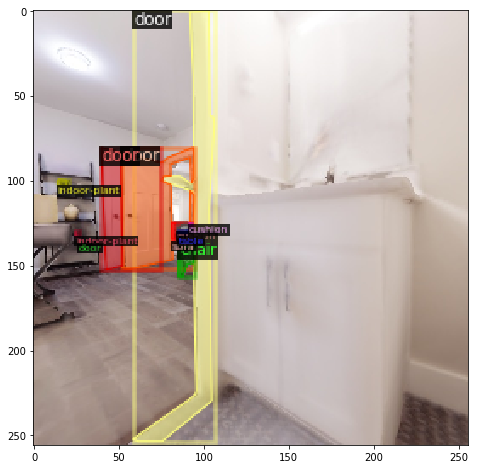

/checkpoint/apratik/finals/straightline/apartment_0/rgb/03194.jpg


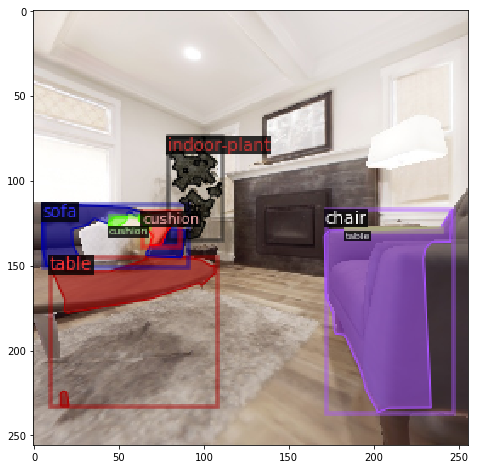

  0%|          | 0/200 [00:00<?, ?it/s]

Init CocoCreator for labels ['chair', 'cushion', 'door', 'indoor-plant', 'sofa', 'table']
Using habitat semantic json /datasets01/replica/061819/18_scenes/apartment_0/habitat/info_semantic.json
Scene apartment_0, seg dir /checkpoint/apratik/finals/default/apartment_0/pred_label_gt50p2fix_corl
Creating COCO annotations for 200 images 
 img_dir /checkpoint/apratik/finals/default/apartment_0/rgb


100%|██████████| 200/200 [00:36<00:00,  5.41it/s]


Dumping annotations to default_apt0_gt50p2fix_corlnn.json
829 829
/checkpoint/apratik/finals/default/apartment_0/rgb/00217.jpg


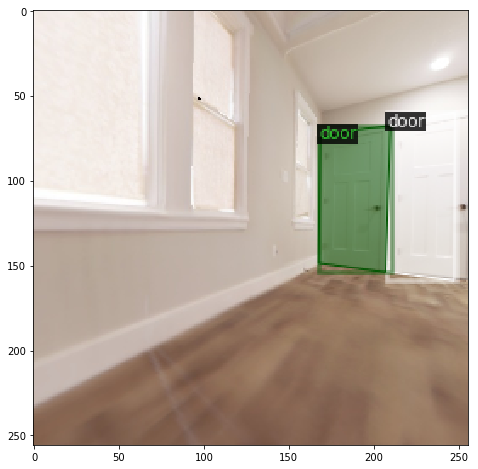

/checkpoint/apratik/finals/default/apartment_0/rgb/01241.jpg


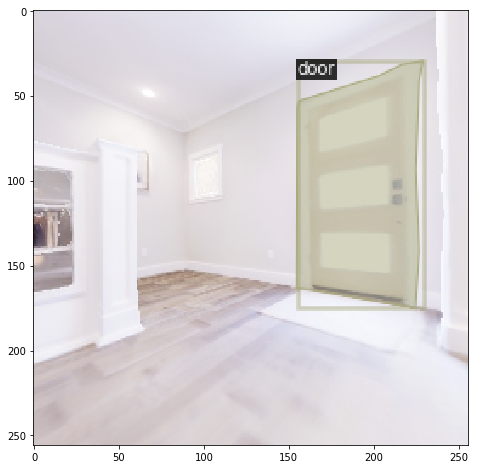

  0%|          | 0/400 [00:00<?, ?it/s]

Init CocoCreator for labels ['chair', 'cushion', 'door', 'indoor-plant', 'sofa', 'table']
Using habitat semantic json /datasets01/replica/061819/18_scenes/apartment_0/habitat/info_semantic.json
Scene apartment_0, seg dir /checkpoint/apratik/finals/straightline/apartment_0/pred_label_gt100p2fix_corl
Creating COCO annotations for 400 images 
 img_dir /checkpoint/apratik/finals/straightline/apartment_0/rgb


100%|██████████| 400/400 [01:23<00:00,  4.80it/s]


Dumping annotations to straightline_apt0_gt100p2fix_corlnn.json
2414 2414
/checkpoint/apratik/finals/straightline/apartment_0/rgb/00908.jpg


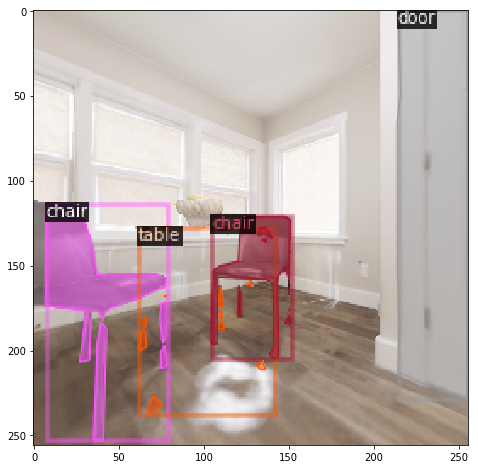

/checkpoint/apratik/finals/straightline/apartment_0/rgb/01156.jpg


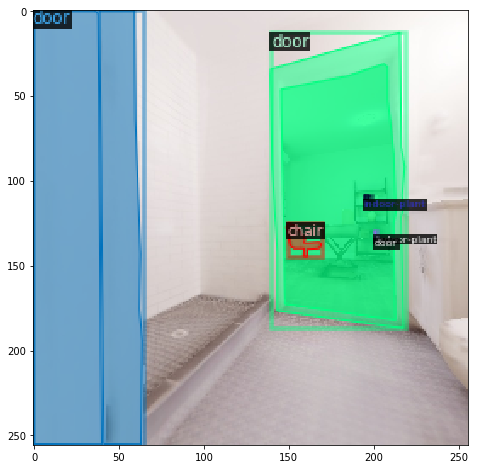

  0%|          | 0/400 [00:00<?, ?it/s]

Init CocoCreator for labels ['chair', 'cushion', 'door', 'indoor-plant', 'sofa', 'table']
Using habitat semantic json /datasets01/replica/061819/18_scenes/apartment_0/habitat/info_semantic.json
Scene apartment_0, seg dir /checkpoint/apratik/finals/default/apartment_0/pred_label_gt100p2fix_corl
Creating COCO annotations for 400 images 
 img_dir /checkpoint/apratik/finals/default/apartment_0/rgb


  3%|▎         | 12/400 [00:03<02:06,  3.06it/s]


KeyboardInterrupt: 

In [2]:
seg_folder=['gt50p2fix_corl', 'gt100p2fix_corl', 'gt150p2fix_corl', 'gt200p2fix_corl', 'gt250p2fix_corl'] 

# Create the active and baseline jsons for each setting
for seg_folder in seg_folder:
    cactive = CocoCreator('/checkpoint/apratik/finals/straightline', semantic_json_root, labels)
    cactive.create_coco(
        scene='apartment_0', 
        coco_file_name='straightline_apt0_'+seg_folder+'nn.json', 
        seg_folder='pred_label_'+seg_folder, 
        pct=1 # always 1 for training on propagated labels
    )

    cbase = CocoCreator('/checkpoint/apratik/finals/default', semantic_json_root, labels)
    cbase.create_coco(
        scene='apartment_0', 
        coco_file_name='default_apt0_'+seg_folder+'nn.json', 
        seg_folder='pred_label_'+seg_folder, 
        pct=1 # always 1 for training on propagated labels
    )


In [ ]:
# c.create_coco('apartment_0', 'default_apt0_100gt.json', 'pred_label_gt100', 1)

In [ ]:
# Create a Test set

# ctest = CocoCreator('/checkpoint/apratik/ActiveVision/active_vision/replica_random_exploration_data', semantic_json_root, labels)
# ctest.create_coco('frl_apartment_1', 'frlapt1_20n.json', 'seg', 0.2)